In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import numpy as np
from sklearn.metrics import silhouette_score
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
df = pd.read_csv("PIANO_comments.csv")

In [4]:
#vedere per ogni autore il numero di post tossici
grouped = df.groupby('author')
post_per_user = grouped.agg(
nbr_posts=('author', 'size'),
toxic_posts=('toxic', 'sum')
).reset_index()

post_per_user["perc"] = round((post_per_user["toxic_posts"]/post_per_user["nbr_posts"])*100)

In [5]:
post_per_user

,author,nbr_posts,toxic_posts,perc
0,t2_100w5k,3,1,33.0
1,t2_101gwc,336,22,7.0
2,t2_101nfp,558,51,9.0
3,t2_1023m3xz,13,3,23.0
4,t2_102eed5v,141,28,20.0
...,...,...,...,...
15716,t2_zykuy,1072,137,13.0
15717,t2_zyq04,1231,76,6.0
15718,t2_zzfwi,35,1,3.0
15719,t2_zzrbf,1320,165,12.0


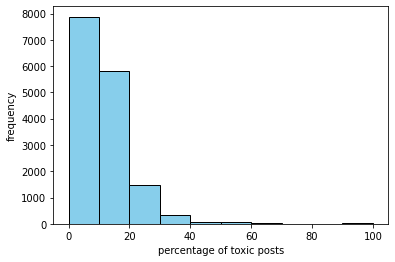

In [6]:
plt.hist(post_per_user["perc"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('percentage of toxic posts')
plt.ylabel('frequency')
plt.show()

#right_skewed


In [7]:
freq, bins = np.histogram(post_per_user["perc"], bins=10) #15721
for i in range(0, 10):
    print(i, (freq[i]/len(post_per_user)*100), freq[i])

0 50.11131607404109 7878
1 36.95693658164239 5810
2 9.45232491571783 1486
3 2.2326823993384646 351
4 0.44526429616436614 70
5 0.4134597035811971 65
6 0.08905285923287323 14
7 0.02544367406653521 4
8 0.03816551109980281 6
9 0.23535398511545066 37


## users dataset 

dataset contenente info relative agli users

In [8]:
feature_df = df.columns.tolist()
feature_df[43:70]

['die',
 'dumb',
 'go',
 'stupid',
 'black',
 'oh',
 'shit',
 'ass',
 'people',
 'white',
 'fuckin',
 'get',
 'fucking',
 'bootlicker',
 'racist',
 'fuck',
 'idiot',
 'want',
 'just',
 'gay',
 'holy',
 'bitch',
 'would',
 'like',
 'shut',
 'kill',
 'think']

# aggregation

In [14]:
feature_df = df.columns.tolist()
no_feature_sum = ["author", "text", "subreddit","emoji_unique","emoji_list","date","time_of_day","cluster"]
no_feature_mean = ["toxic"] + no_feature_sum + feature_df[43:70]


def extract_features(dframe, features):
    #raggruppo per autore
    grouped = dframe.groupby('author')

    post_per_user = grouped.agg(
    nbr_posts=('author', 'size'),
    toxic_posts=('toxic', 'sum')
    ).reset_index()

    #numero di subreddit distinti per autore
    post_per_user["nbr_subreddit"] = grouped["subreddit"].nunique().values
    
    #numero di commenti per cluster
    pivot_table = dframe.pivot_table(index=dframe["author"], columns=dframe["cluster"], aggfunc='size', fill_value=0)
    for i in range(0, 5):
        post_per_user["cluster_"+str(i)]=pivot_table[i].values
        
    
    
    #PARTE RELATIVA ALLA SOMMA
    # Seleziona solo le colonne desiderate per la somma
    colonne_somma = [feat for feat in features if feat not in no_feature_sum]
    # Calcola le somme delle colonne desiderate per ogni autore
    sums = grouped[colonne_somma].sum().reset_index()
    # Unisci i risultati basati sull'autore
    df_user = post_per_user.merge(sums, on='author')
    # Rinomina le colonne aggiungendo "_sum" dove necessario
    for feat in colonne_somma:
        df_user.rename(columns={feat: feat+"_sum"}, inplace=True)

    #PARTE RELATIVA ALLA MEDIA:
    colonne_media = [feat for feat in features if feat not in no_feature_mean]
    means = grouped[colonne_media].mean().reset_index()
    df_user_mean = df_user.merge(means, on='author')
    for feat_mean in colonne_media:
        df_user_mean.rename(columns={feat_mean: feat_mean+"_mean"}, inplace=True)

    #Valori massimi
    colonne_max = colonne_media
    maxs = grouped[colonne_max].max().reset_index()
    df_user_max = df_user_mean.merge(maxs, on='author')
    for feat_max in colonne_max:
        df_user_max.rename(columns={feat_max: feat_max+"_max"}, inplace=True)

    #Valori minimi
    colonne_min = colonne_media
    mins = grouped[colonne_min].min().reset_index()
    df_user_min = df_user_max.merge(mins, on='author')
    for feat_min in colonne_min:
        df_user_min.rename(columns={feat_min: feat_min+"_min"}, inplace=True)
        
    #quanti e quali tossicità sopra la media
    df_user_min["tox_over"]=0
    df_user_min["tox_list"] = [[] for _ in range(len(post_per_user))]
    dict_tox_feat_mean = dict(df.iloc[:,4:10].mean())
    for i, v in dict_tox_feat_mean.items():
        mask = df_user_min[i+"_mean"] >= v
        df_user_min.loc[mask, "tox_over"] += 1
        df_user_min.loc[mask, "tox_list"] = df_user_min.loc[mask, "tox_list"].apply(lambda x: x + [i])
        
        
    #quante e quali emozioni sopra la media
    df_user_min["emotion_over"]=0
    df_user_min["emotion_list"] = [[] for _ in range(len(post_per_user))]
    dict_em_mean = dict(df.iloc[:,[18,19,20,21,22,25,26,27]].mean())
    for i, v in dict_em_mean.items():
        mask = df_user_min[i+"_mean"] >= v
        df_user_min.loc[mask, "emotion_over"] += 1
        df_user_min.loc[mask, "emotion_list"] = df_user_min.loc[mask, "emotion_list"].apply(lambda x: x + [i])
    

    return df_user_min




In [15]:
df_user_def = extract_features(df, feature_df)

In [16]:
df_user_def

,author,nbr_posts,toxic_posts,nbr_subreddit,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,score_sum,...,polarity_min,valence_min,arousal_min,dominance_min,toxic_words_min,gunning_fog_min,tox_over,tox_list,emotion_over,emotion_list
0,t2_100w5k,3,1,2,0,2,0,1,0,4,...,-0.150000,0.14515,0.098150,0.1313,0,NaN,4,"[toxicity, severe_toxicity, obscene, insult]",5,"[fear, anger, anticip, sadness, disgust]"
1,t2_101gwc,336,22,29,7,288,7,18,16,1653,...,-0.700000,0.00000,0.000000,0.0000,0,41.976471,0,[],7,"[fear, anger, anticip, trust, surprise, sadnes..."
2,t2_101nfp,558,51,125,16,476,16,22,28,3770,...,-1.000000,0.00000,0.000000,0.0000,0,41.984158,1,[threat],1,[anticip]
3,t2_1023m3xz,13,3,8,0,10,0,3,0,912,...,-0.230556,0.01460,0.093022,0.0862,0,44.681481,2,"[toxicity, obscene]",5,"[fear, anger, anticip, disgust, joy]"
4,t2_102eed5v,141,28,49,9,95,19,2,16,-249,...,-1.000000,0.00000,0.000000,0.0000,0,49.155140,5,"[toxicity, severe_toxicity, threat, insult, id...",3,"[anger, anticip, disgust]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15716,t2_zykuy,1072,137,44,46,816,55,70,85,19706,...,-1.000000,0.00000,0.000000,0.0000,0,44.400000,4,"[toxicity, severe_toxicity, obscene, insult]",7,"[anger, anticip, trust, surprise, sadness, dis..."
15717,t2_zyq04,1231,76,62,17,1056,56,18,84,13014,...,-1.000000,0.00000,0.000000,0.0000,0,54.950000,2,"[threat, identity_attack]",1,[anticip]
15718,t2_zzfwi,35,1,6,0,34,0,1,0,270,...,-0.450000,0.00000,0.000000,0.0000,0,NaN,0,[],2,"[anticip, surprise]"
15719,t2_zzrbf,1320,165,242,48,1027,75,67,103,13062,...,-1.000000,0.00000,0.000000,0.0000,0,43.964356,3,"[toxicity, insult, identity_attack]",7,"[fear, anger, anticip, trust, surprise, sadnes..."


In [34]:
colonne_user = df_user_def.columns.to_list()
len(colonne_user)

181

## subreddit-comment ratio

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
#ratio compreso tra 0 e 1, se è vicino a 1 l'autore è sedentario, concentra i commenti n pochi subreddit
df_user_def["ratio"] = scaler.fit_transform((df_user_def['nbr_posts'] / df_user_def['nbr_subreddit']).values.reshape(-1, 1))
df_user_def["ratio_toxic"] = scaler.fit_transform((df_user_def['toxic_posts'] / df_user_def['nbr_subreddit']).values.reshape(-1, 1))

In [ ]:
#df_user_def.to_csv("../file_csv/PIANO_user.csv", index = False)